# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [4]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from datetime import datetime
from sklearn.decomposition import PCA


# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\Ali\AppData\Local\Temp\ipykernel_17612\1960795267.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\Ali\AppData\Local\Temp\ipykernel_17612\1960795267.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')


**Assessing Data**

In [6]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [7]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


**Identification of data types**

In [8]:
customers.dtypes

LNR                       int64
AGER_TYP                  int64
AKT_DAT_KL              float64
ALTER_HH                float64
ALTER_KIND1             float64
                         ...   
PRODUCT_GROUP            object
CUSTOMER_GROUP           object
ONLINE_PURCHASE           int64
ANREDE_KZ                 int64
ALTERSKATEGORIE_GROB      int64
Length: 369, dtype: object

In [9]:
df_float = customers.select_dtypes('float').columns
df_object = customers.select_dtypes('object').columns
df_int = customers.select_dtypes('int64').columns
df_bool = customers.select_dtypes('bool').columns
df_datetime = customers.select_dtypes('datetime64').columns
print("Floats ="+ str(df_float.shape[0])+ " / Objects ="+str(df_object.shape[0]) +" / Ints ="+str(df_int.shape[0])+" / Bools ="+ str(df_bool.shape[0])+" / Datetimes ="+ str(df_datetime.shape[0]))


Floats =267 / Objects =8 / Ints =94 / Bools =0 / Datetimes =0


In [10]:
#listing all the object types
df_object

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')

In [11]:
for col in df_object:
    print('Column {} has {} unique columns has follow \n {}'.format(col,len(customers[col].unique()),customers[col].unique()))

Column CAMEO_DEU_2015 has 46 unique columns has follow 
 ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D' 'XX']
Column CAMEO_DEUG_2015 has 20 unique columns has follow 
 [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
Column CAMEO_INTL_2015 has 44 unique columns has follow 
 [13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']
Column D19_LETZTER_KAUF_BRANCHE has 36 unique columns has follow 
 ['D19_UNBEKANNT' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE'
 'D19_BUCH_CD' 'D19_DROGERIEARTIKEL' 'D19_SONSTIGE' 'D19_TECHNIK'
 'D19_VERSICHERUNGEN' 'D19_TELKO_MOBILE' 'D19_VOLLSORTIMENT' nan
 'D19_HAUS_DEK

Some cleaning will have to be done on those columns in order to be able to normalize them later.

In [12]:
#looking at numerical values
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


**Looking at missing values**

In [13]:
#Looking at Missing values

df_missing = customers.columns[customers.isnull().any()]
df_missing_num = customers[df_missing].isnull().sum()/len(customers)
df_missing_num.sort_values(ascending=True, inplace=True)
df_missing_num

HH_EINKOMMEN_SCORE    0.015486
CJT_TYP_6             0.016765
CJT_TYP_1             0.016765
CJT_KATALOGNUTZER     0.016765
CJT_GESAMTTYP         0.016765
                        ...   
KK_KUNDENTYP          0.584064
ALTER_KIND1           0.938607
ALTER_KIND2           0.973389
ALTER_KIND3           0.993347
ALTER_KIND4           0.998769
Length: 273, dtype: float64

In [14]:
df_missing_num.index

Index(['HH_EINKOMMEN_SCORE', 'CJT_TYP_6', 'CJT_TYP_1', 'CJT_KATALOGNUTZER',
       'CJT_GESAMTTYP', 'ONLINE_AFFINITAET', 'CJT_TYP_4', 'RETOURTYP_BK_S',
       'RT_KEIN_ANREIZ', 'RT_SCHNAEPPCHEN',
       ...
       'KBA05_MOD8', 'KBA05_ALTER2', 'KBA05_MAXHERST', 'KBA05_ANHANG',
       'EXTSEL992', 'KK_KUNDENTYP', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4'],
      dtype='object', length=273)

<function matplotlib.pyplot.show(close=None, block=None)>

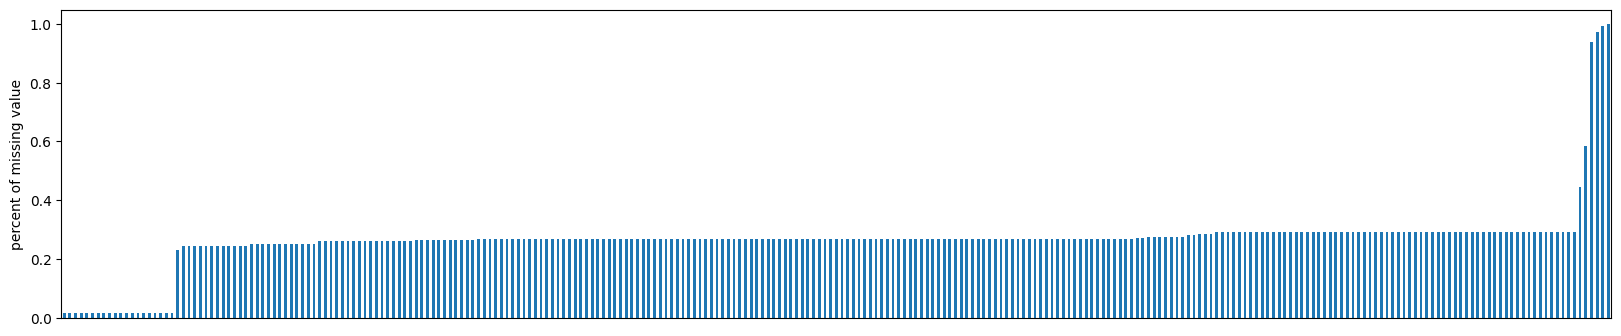

In [17]:
#Plotting the missing values
ax = df_missing_num.plot(kind="bar", figsize=(20,4));
plt.xlabel('Attributes')
plt.ylabel('percent of missing value')
ax.xaxis.set_visible(False)
plt.show

In [18]:
# We can clearly see a few attributes being over 40% empty, this won't be properly usable for ML, hence we can remove them
removed_missing = df_missing_num[df_missing_num > 0.4]
print(removed_missing)

EXTSEL992       0.444989
KK_KUNDENTYP    0.584064
ALTER_KIND1     0.938607
ALTER_KIND2     0.973389
ALTER_KIND3     0.993347
ALTER_KIND4     0.998769
dtype: float64


In [19]:
# After looking at the documentation, it looks like when the information is unknown the categorical values are either set to X, XX, or -1
df_unknown = customers.isin(['-1','X','XX'])
df_unknown = df_unknown[df_unknown == True].sum()/len(customers)
df_unknown.sort_values(ascending=True, inplace=True)
df_unknown

LNR                             0.0
KBA13_KRSHERST_BMW_BENZ         0.0
KBA13_KRSHERST_AUDI_VW          0.0
KBA13_KRSAQUOT                  0.0
KBA13_KMH_251                   0.0
                             ...   
KBA05_ANTG2                     0.0
ALTERSKATEGORIE_GROB            0.0
CAMEO_DEU_2015             0.000657
CAMEO_DEUG_2015            0.000657
CAMEO_INTL_2015            0.000657
Length: 369, dtype: object

<function matplotlib.pyplot.show(close=None, block=None)>

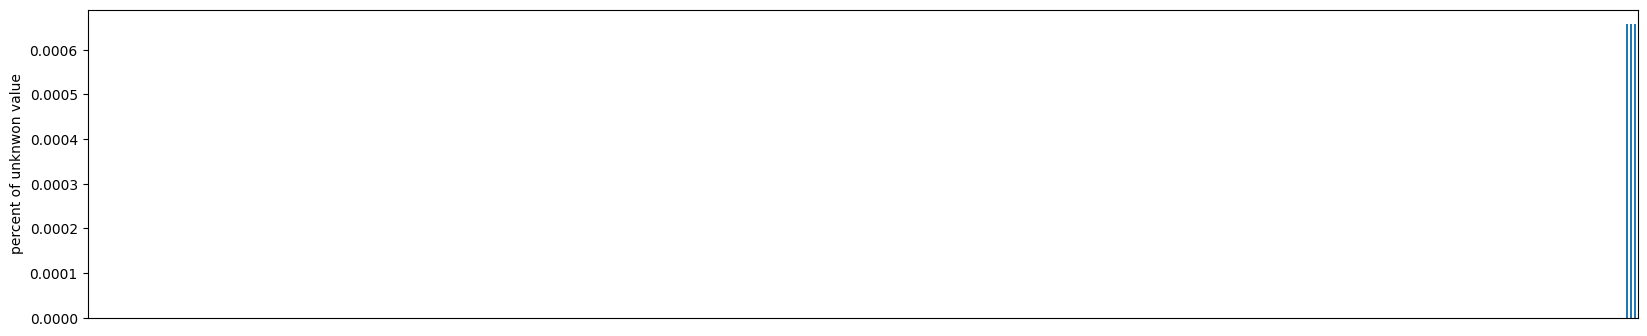

In [20]:
#Plotting the unknown values
ax = df_unknown.plot(kind="bar", figsize=(20,4));
plt.xlabel('Attributes')
plt.ylabel('percent of unknwon value')
ax.xaxis.set_visible(False)
plt.show

In [23]:
# We can clearly see 3 attribute from the rest, let's see which ones
removed_unknown = df_unknown[df_unknown > 0.0005]
print(removed_unknown)


CAMEO_DEU_2015     0.000657
CAMEO_DEUG_2015    0.000657
CAMEO_INTL_2015    0.000657
dtype: object


Those are already planned to be cleaned in the step.

**Data Preprocessing**

In [24]:
# We Clean the object typed attributes
# For each we will transform string / categorical values into ints from 0 to n
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
print(df_object)
le = preprocessing.LabelEncoder()

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ',
       'PRODUCT_GROUP', 'CUSTOMER_GROUP'],
      dtype='object')


In [25]:
# CAMEO_DEU_2015
print(customers.CAMEO_DEU_2015.unique())
customers['CAMEO_DEU_2015'] = customers['CAMEO_DEU_2015'].replace(np.nan, 'XX')
customers['CAMEO_DEU_2015'] = le.fit_transform(customers['CAMEO_DEU_2015'])
print(customers.CAMEO_DEU_2015.unique())

['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C'
 '5A' '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D'
 '6F' '4D' 'XX']
[ 0 44 21 15 31 10  3 43  8 13 25 42 36 20 41 17 26 37 35 19 40 12  5 11
 23 30  4  7 32 18  6 27 34 22 28  9 39 14  2  1 24 38 33 29 16]


In [26]:
# CAMEO_DEUG_2015
print(customers.CAMEO_DEUG_2015.unique())
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace([np.nan, 'X'], 0)
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].astype(int)
print(customers.CAMEO_DEUG_2015.unique())

[1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
[1 0 5 4 7 3 9 2 6 8]


In [27]:
# CAMEO_INTL_2015
print(customers.CAMEO_INTL_2015.unique())
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].replace([np.nan, 'XX'], 0)
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].astype(int)
print(customers.CAMEO_INTL_2015.unique())

[13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43'
 '22' '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33'
 'XX']
[13  0 34 24 41 23 15 55 14 22 43 51 33 25 44 54 32 12 35 31 45 52]


In [28]:
# D19_LETZTER_KAUF_BRANCHE
print(customers.D19_LETZTER_KAUF_BRANCHE.unique())
customers['D19_LETZTER_KAUF_BRANCHE'] = le.fit_transform(customers['D19_LETZTER_KAUF_BRANCHE'])
print(customers.D19_LETZTER_KAUF_BRANCHE.unique())


['D19_UNBEKANNT' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE'
 'D19_BUCH_CD' 'D19_DROGERIEARTIKEL' 'D19_SONSTIGE' 'D19_TECHNIK'
 'D19_VERSICHERUNGEN' 'D19_TELKO_MOBILE' 'D19_VOLLSORTIMENT' nan
 'D19_HAUS_DEKO' 'D19_ENERGIE' 'D19_REISEN' 'D19_BANKEN_LOKAL'
 'D19_VERSAND_REST' 'D19_BEKLEIDUNG_REST' 'D19_FREIZEIT'
 'D19_BEKLEIDUNG_GEH' 'D19_TELKO_REST' 'D19_SAMMELARTIKEL'
 'D19_BANKEN_DIREKT' 'D19_KINDERARTIKEL' 'D19_BANKEN_REST'
 'D19_LEBENSMITTEL' 'D19_GARTEN' 'D19_HANDWERK' 'D19_RATGEBER'
 'D19_DIGIT_SERV' 'D19_BIO_OEKO' 'D19_BILDUNG' 'D19_WEIN_FEINKOST'
 'D19_TIERARTIKEL' 'D19_LOTTO' 'D19_KOSMETIK']
[30  1 20 24  8 10 25 26 32 27 33 35 15 11 22  2 31  5 12  4 28 23  0 16
  3 18 13 14 21  9  7  6 34 29 19 17]


In [29]:
# EINGEFUEGT_AM
print(customers.EINGEFUEGT_AM.unique())
customers['EINGEFUEGT_AM'] = customers['EINGEFUEGT_AM'].str[:4]
customers['EINGEFUEGT_AM'] = customers['EINGEFUEGT_AM'].replace([np.nan], 0)
customers['EINGEFUEGT_AM'] = customers['EINGEFUEGT_AM'].astype(int)
print(customers['EINGEFUEGT_AM'].unique())

['1992-02-12 00:00:00' nan '1992-02-10 00:00:00' ... '2008-04-25 00:00:00'
 '2005-03-30 00:00:00' '2008-07-14 00:00:00']
[1992    0 2004 1997 1995 2007 2005 1996 2012 1994 2008 2003 2006 1993
 1998 2015 2011 2000 1999 2009 2010 2002 2014 2001 2013 2016]


In [30]:
# OST_WEST_KZ
print(customers.OST_WEST_KZ.unique())
customers['OST_WEST_KZ'] = customers['OST_WEST_KZ'].replace(np.nan, 'XX')
customers['OST_WEST_KZ'] = le.fit_transform(customers['OST_WEST_KZ'])
print(customers.OST_WEST_KZ.unique())

['W' nan 'O']
[1 2 0]


In [31]:
#dropping missing & unknown cols with >30%
customers.drop([col for col in removed_unknown.index], axis=1, inplace=True)
customers.drop([col for col in removed_missing.index], axis=1, inplace=True)
customers.shape

(191652, 360)

In [32]:
#Removing the customer dataset specific columns (CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP') and the unique identifier for customer 'LNR'
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE','PRODUCT_GROUP','LNR'], inplace=True)

In [33]:
#In order to use next steps of the project we now need to get rid of the rest of the NaN values
# https://scikit-learn.org/stable/modules/impute.html
nan_count = customers.isna().sum().sum()
not_null_count = customers.notnull().sum().sum()
print('{} NaN values representing {}% of the dataset'.format(nan_count, (nan_count/not_null_count)*100))
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(customers)
customers = pd.DataFrame(imputer.transform(customers),columns=customers.columns)
print(customers.isna().sum().sum())

12620236 NaN values representing 22.695051326901964% of the dataset
0


In [34]:
#Last, we need to normalize the dataset. This will transfrom each column individually in order to have distribution with a mean of 0 and stddev of 1
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers)


In [35]:
customers_scaled

array([[ 1.18968086, -0.43697728, -0.24765912, ...,  0.36217405,
        -0.77696529,  0.86452659],
       [-0.9660048 ,  4.23954563, -0.0644805 , ...,  0.36217405,
        -0.77696529,  0.86452659],
       [-0.9660048 , -0.43697728, -0.98037359, ...,  0.36217405,
         1.28705878,  0.86452659],
       ...,
       [ 1.18968086, -0.43697728,  0.66823397, ...,  0.36217405,
        -0.77696529,  0.86452659],
       [ 1.90824275, -0.43697728,  0.30187674, ...,  0.36217405,
         1.28705878, -0.05607109],
       [ 1.90824275, -0.43697728, -2.0794453 , ..., -1.34944732,
        -0.77696529, -0.97666877]])

In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

**Principal Component Analysis**
Due to the fact that the dataset is quite large, we hope to reduce its size by selecting only the components that have the biggest impact on variance.


In [58]:
pca = PCA()
customer_pca = pca.fit_transform(customers_scaled)

In [62]:
pca.explained_variance_

array([3.15216749e+01, 2.12465959e+01, 1.74046550e+01, 1.50072193e+01,
       1.23729478e+01, 7.09983520e+00, 6.86489412e+00, 5.64516535e+00,
       5.32565568e+00, 5.28746723e+00, 4.62879754e+00, 4.35808677e+00,
       4.16160926e+00, 3.94761001e+00, 3.85045679e+00, 3.43857844e+00,
       3.27127700e+00, 3.23903399e+00, 3.21762468e+00, 3.06003175e+00,
       2.92156116e+00, 2.76940067e+00, 2.69611392e+00, 2.67620359e+00,
       2.50260495e+00, 2.44619119e+00, 2.36442831e+00, 2.28025912e+00,
       2.21607289e+00, 2.15067137e+00, 2.08725045e+00, 2.02141714e+00,
       1.96306059e+00, 1.94294211e+00, 1.89731487e+00, 1.87971507e+00,
       1.84047283e+00, 1.76844452e+00, 1.72891817e+00, 1.68231990e+00,
       1.66627146e+00, 1.61796262e+00, 1.57735280e+00, 1.55845655e+00,
       1.53905499e+00, 1.49341655e+00, 1.46225376e+00, 1.44700040e+00,
       1.44285481e+00, 1.38722475e+00, 1.36797466e+00, 1.36146609e+00,
       1.34607802e+00, 1.31528667e+00, 1.29061924e+00, 1.27912552e+00,
      

In [60]:
pca.components_

array([[ 7.89139201e-02, -1.93930968e-02,  4.48038504e-02, ...,
        -7.17263077e-02, -4.69985073e-02,  1.02721491e-01],
       [ 6.58755815e-02,  2.00802945e-02, -3.44841341e-02, ...,
         3.17383780e-02,  4.39074187e-03,  6.34027940e-02],
       [-4.87450525e-03, -7.88813073e-03, -7.39601578e-03, ...,
        -5.49693622e-02, -1.88299255e-02, -1.36192441e-02],
       ...,
       [ 2.54969754e-03, -6.59409511e-04,  4.93420567e-03, ...,
        -7.73799279e-04,  2.16231718e-04, -2.33730396e-03],
       [-3.19641795e-04,  8.35590797e-05,  2.13937480e-03, ...,
        -3.65547549e-04, -5.06486108e-04,  1.97794596e-04],
       [-9.16965986e-17,  5.27585943e-17, -1.86417868e-17, ...,
         1.33318324e-17,  1.39769913e-17,  2.41986906e-17]])

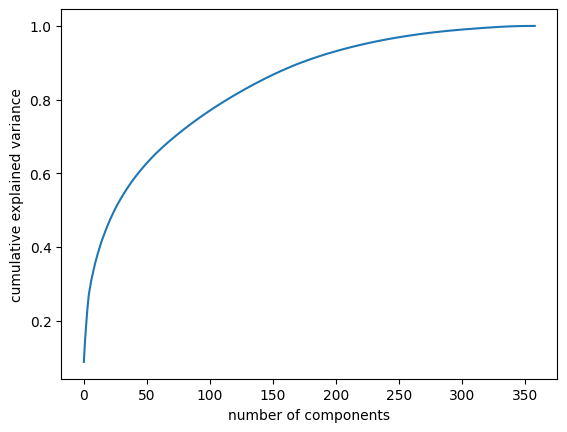

In [61]:
# We can now look at the cumulative explaine variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [74]:
# In order to maintain 75% of variance check the number of components needed
np.count_nonzero(np.cumsum(pca.explained_variance_ratio_)<0.75)

92

In [76]:
pca.components_[0].shape

(359,)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')